In [18]:
# import libraries

# handle dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score
import warnings
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model

# Data set from https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data

In [28]:
# split train test dataset 

df = pd.read_csv('Loan_Default.csv')
# remove some variables that are redundant 
# year, ID
# Interest_rate_spread and rate_of_interest are dropped due to the fact that their values are NA where the loan has defaulted 
# open credit , secured by, total units : only has one value or too few observations 

print(df.columns)
df = df.drop(['year', 'ID', 'Interest_rate_spread' ,'rate_of_interest', 'open_credit','Secured_by','total_units',"approv_in_adv",'loan_purpose','loan_type'], axis=1)
# print(df['Status'].value_counts())
# print(df.isna().sum())

# Assumption 1 : We assume that upfront charges that are missing are 0 
df['Upfront_charges'] = df['Upfront_charges'].fillna(0) 
# Assumption 2 : We focus on mortgage loans 
df = df.dropna(subset=["property_value"])
# Assumption 3 : drop approv in adv that is NA (only small set of samples)
# df = df.dropna(subset=["Neg_ammortization"])
df = df.dropna(subset=["term"])
df = df.dropna(subset=["income"])
# print(df['Status'].value_counts())

# print(df.loc[df['Status'] == 1].head())
# print(df.head())
print(df["LTV"].isna().sum())
# print(df.isna().sum())
print("Number of rows : " , len(df.index))
# LTV = Loan to Value -> compares the loan value to the value of the asset being purchased as a part of the loan 
# Property Value 
print(df.columns)


Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status', 'dtir1'],
      dtype='object')
0
Number of rows :  124408
Index(['loan_limit', 'Gender', 'Credit_Worthiness', 'business_or_commercial',
       'loan_amount', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'income', 'credit_type',
       'Credit_Score', 'co-applicant_credit_type', 'age',
       'submis

In [29]:
df = pd.concat([df,pd.get_dummies(df["interest_only"], prefix='interest_only')],axis=1)
print(df.columns)
print(df['Status'].corr(df['interest_only_not_int']))


Index(['loan_limit', 'Gender', 'Credit_Worthiness', 'business_or_commercial',
       'loan_amount', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'income', 'credit_type',
       'Credit_Score', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'LTV', 'Region', 'Security_Type', 'Status',
       'dtir1', 'interest_only_int_only', 'interest_only_not_int'],
      dtype='object')
-0.004453762559170784


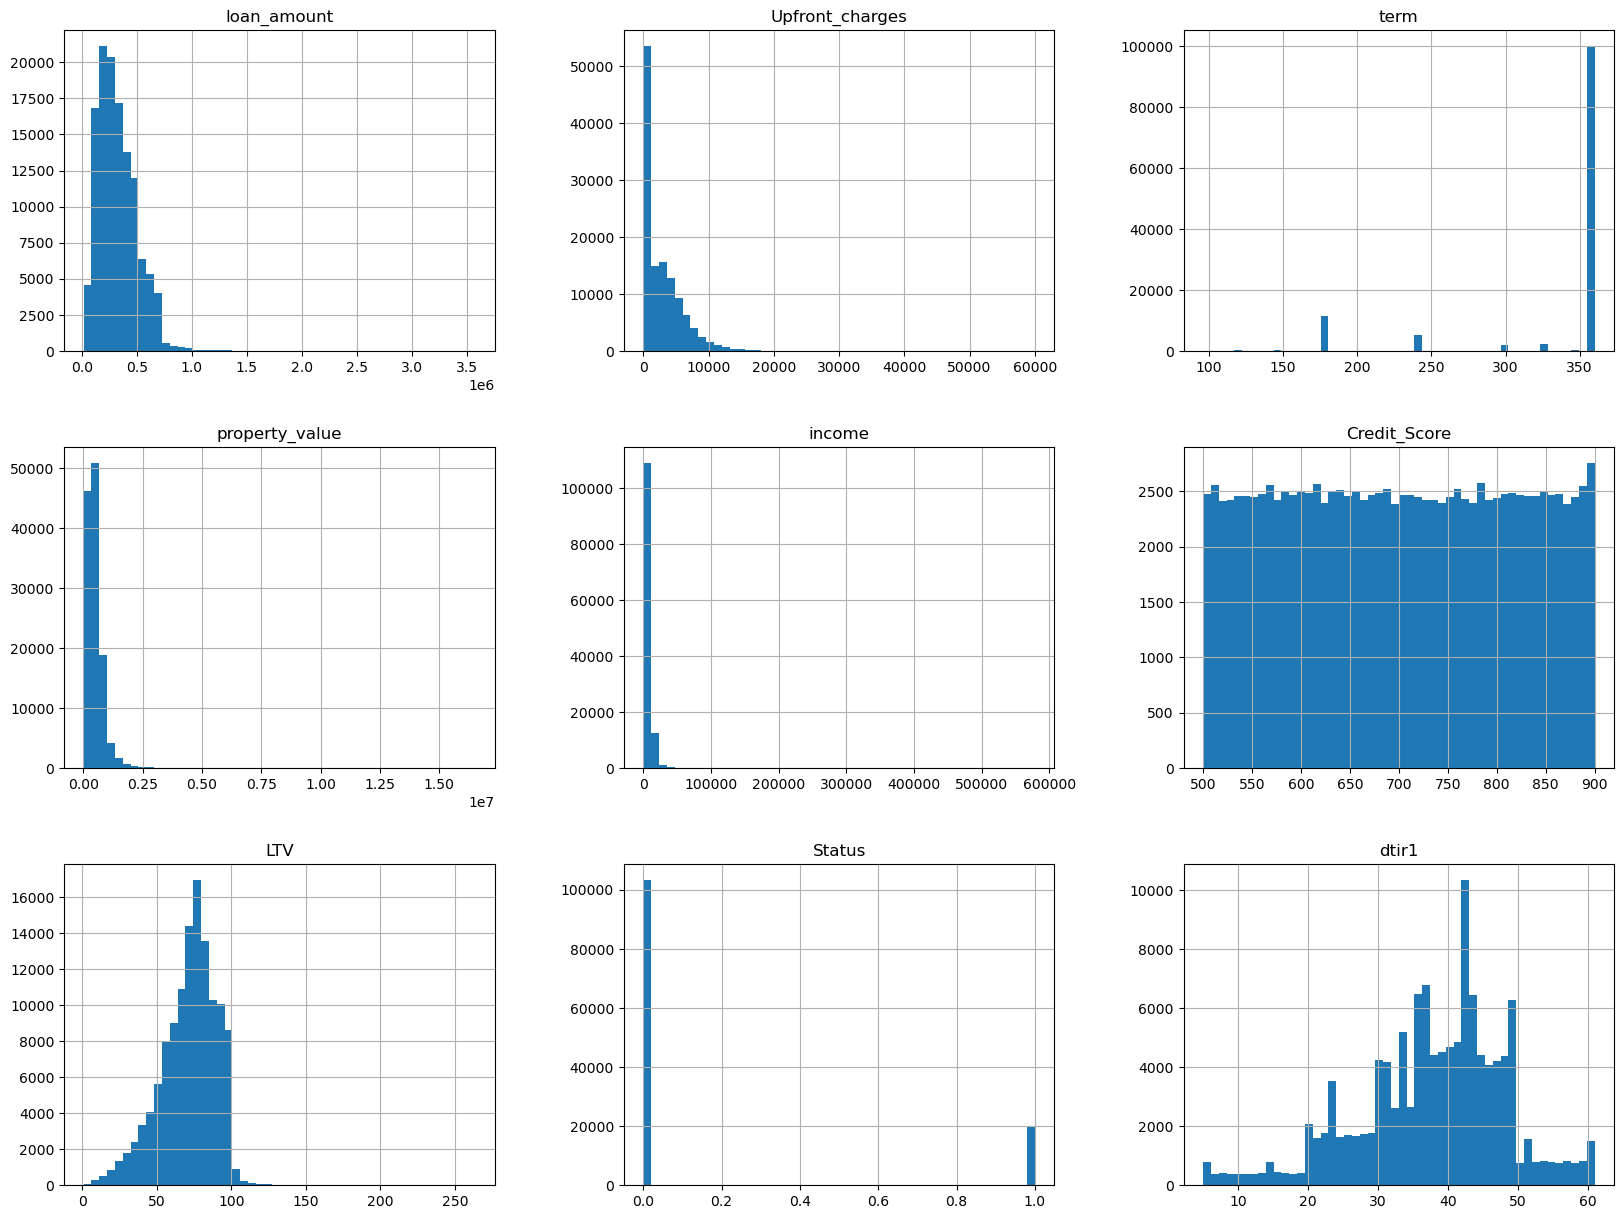

In [41]:
df.hist(bins = 50, figsize = (20, 15))
plt.show()

# Eyeballing the data

So by looking at the data, we see there are two main types of loans : property loan and non-property loan. 


In [21]:
# define X and y variables as dataframe 
y = df['Class']
X = df.iloc[:, df.columns != 'Class']
X_train, X_OOS_test, y_train, y_OOS_test = train_test_split(X, y, test_size=0.20, random_state=66)

In [5]:
from imblearn.over_sampling import SMOTE
# solve error by downgrading to install scikit-learn==1.2.2 
# ''' steps : 
# 1. install pip 
# 2. uninstall sci-kit 
# 3. uninstall imblearn
# 4. install sci-kit 1.2.2 
# 5. install imblearn 
# '''

In [6]:
# Over sample using SMOTE
# -- by inspecting the data, we see that the minority class is extremely class (fraud "Class" == 1)
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [7]:
# -- Code to Inspect the data set -- 
# df_oversampled = X_smote
# df_oversampled['Outcome_Variable'] = y_smote
# df_oversampled
# fig, ax = plt.subplots(figsize=(10, 8))
# df_oversampled['Outcome_Variable'].value_counts().plot(kind='bar', ax=ax, fontsize=14)
# ax.set_title('Oversampled Dataset', fontsize=16)
# ax.set_ylabel('Observation counts', fontsize=14)
# ax.set_xlabel('Class', fontsize=14)
# plt.show()


In [8]:
# Set up K-Fold Cross Validation 
n_splits = 5
shuffle = True
random_state = 809
cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
# plot = plot_cv_indices(cv, X_smote, y_smote, n_splits)

## Model 1 : Logistic Regression 

In [9]:
def plot_cv_indices(cv, X, y, n_splits, lw=10):
    '''
    This function plots the Cross validation indices.
    '''
    
    fig, ax = plt.subplots(figsize = (15,8))
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Paired)

    # Formatting
    yticklabels = list(range(n_splits)) + ['Class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [191]:
# Model 1 : Logistic Model 
warnings.filterwarnings("default")

logistic_model = LogisticRegression(solver='lbfgs', max_iter=300)
for train_index, test_index in cv.split(X_smote):
    # change to loc to define the rows in the dataframe 
    X_train, X_test, y_train, y_test = X_smote.loc[train_index], X_smote.loc[test_index], y_smote[train_index], y_smote[test_index]
    model.fit(X_train, y_train)
    #Cross-Validation Prediction Error
    score = model.score(X_test, y_test)
    print(score)

0.6993962887477183
0.6974263330539219
0.6990107427000005
0.6963348570692975
0.6986152673174664


In [24]:
model = LogisticRegression(solver='lbfgs', max_iter=300)
model.fit(X_smote, y_smote)    
score_OOS = model.score(X_OOS_test, y_OOS_test)
print ("Logistic Model score :" , score_OOS)
y_pred = model.predict(X_test)
print("Logistic Model Recall : " , recall_score(y_test, y_pred))
print("Logistic Model Precision : ", precision_score(y_test,y_pred))
print("Probability if you only predict 0s ", 1-round(95/56867,3))

Logistic Model score : 0.9833397703732313
Logistic Model Recall :  0.8631578947368421
Logistic Model Precision :  0.08055009823182711
1s in the data set  0.998




## Model 2 : Lasso 

In [1]:
# Model 2 : LASSO 

# Cross Validate the penalty term in lasso
cross_validate_result = {}  
iter_alpha = 0.01
for penalty_term in range(100): 
    print(penalty_term)
    accuracies = [] 
    lasso = linear_model.Lasso(alpha=iter_alpha)
    for train_index, test_index in cv.split(X_smote):
        # change to loc to define the rows in the dataframe 
        X_train, X_test, y_train, y_test = X_smote.loc[train_index], X_smote.loc[test_index], y_smote[train_index], y_smote[test_index]
        model = lasso.fit(X_train, y_train)
        #Cross-Validation Prediction Error
        score = model.score(X_test, y_test)
        accuracies.append(score)
    cross_validate_result[penalty_term] = (sum(accuracies)/len(accuracies))
    iter_alpha += 0.05
    print("Alpha : " + str(iter_alpha) + " " + str((sum(accuracies)/len(accuracies))))
print(cross_validate_result)
print(max(cross_validate_result, key=cross_validate_result.get))
    

0


NameError: name 'linear_model' is not defined

In [16]:
# Somehow LASSO is performing worse?
ols = linear_model.LinearRegression()
ols.fit(X_smote, y_smote)    
y_pred = ols.predict(X_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("OLS Model Recall : " , recall_score(y_test, y_pred_classification))
print("OLS Model Precision : ", precision_score(y_test,y_pred_classification))
print("--")

# LASSO 
lasso = linear_model.Lasso(alpha=1)
lasso.fit(X_smote, y_smote)
y_pred = lasso.predict(X_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("LASSO score : " , )
print("LASSO Model Recall : " , recall_score(y_test, y_pred_classification))
print("LASSO Model Precision : ", precision_score(y_test,y_pred_classification))
print("--")

# RIDGE
ridge = linear_model.Ridge(alpha=1)
ridge.fit(X_smote, y_smote)
y_pred = ridge.predict(X_test)
# turn the continous value into classification via simple >= 0.5 is 1 
y_pred_classification = [1 if x >= 0.5 else 0 for x in y_pred]
print("Ridge Model Recall : " , recall_score(y_test, y_pred_classification))
print("Ridge Model Precision : ", precision_score(y_test,y_pred_classification))

OLS Model Recall :  0.8740848548998853
OLS Model Precision :  0.9868791236150878
--
LASSO score : 
LASSO Model Recall :  0.7958013583840522
LASSO Model Precision :  0.9852571802992246
--
Ridge Model Recall :  0.8740848548998853
Ridge Model Precision :  0.9868791236150878


Looks like the curse of dimensionality. 
